# Supervision des réseaux
## Détection d'intrusion : Méthode Lakhina Entropy
<div>
Groupe 9 :
<ul><li>AMATU Jonathan</li><li>BERCY Victor</li><li>SEMPERE Nicolas</li>
</div>
<div></div>
<div>Dataset CTU-13 : <a href=https://www.stratosphereips.org/datasets-ctu13>lien</a></div>
<div></div>
<div>[1] Papier original : An empirical comparison of botnet detection methods, S. García et al.</div>
<div>[2] Papier Lakhina Entropy : Mining anomalies using traffic feature distributions, A. Lakhina et al.</div>

### 0 - Imports

In [2]:
# Bibliothèques scientifiques
import math
import pandas as pd
import numpy as np
from numpy import linalg as LA

# Bibliothèque de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

# Bibliothèque graphique
import matplotlib.pyplot as plt

# Boîte à outils
from datetime import datetime
import warnings

#### 1 - Pré-traitement du jeu de données

On charge les données d'un scénario dans un dataframe pour l'analyse statistique.

In [3]:
num_scenario = 42
kept_fields = ["StartTime","Dur","Proto","SrcAddr","Sport","DstAddr","Dport","TotPkts","TotBytes","Label"]

scenario = pd.read_csv(f'./Datasets/CTU13_{num_scenario}.binetflow', usecols=kept_fields)
scenario

,StartTime,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,TotPkts,TotBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,12,875,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,2,135,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,2,120,flow=Background
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,3,180,flow=Background
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,42,2856,flow=Background-UDP-Established
...,...,...,...,...,...,...,...,...,...,...
2824631,2011/08/10 15:54:07.352393,0.000393,udp,147.32.86.92,36363,147.32.80.9,53,2,208,flow=To-Background-UDP-CVUT-DNS-Server
2824632,2011/08/10 15:54:07.353854,0.000935,udp,58.165.41.84,60122,147.32.84.229,13363,2,539,flow=Background-UDP-Established
2824633,2011/08/10 15:54:07.357302,0.000000,tcp,147.32.84.171,47077,78.191.168.43,13754,1,74,flow=Background-TCP-Attempt
2824634,2011/08/10 15:54:07.366830,0.002618,udp,93.79.39.15,10520,147.32.84.229,13363,2,520,flow=Background-UDP-Established


Les labels ayant des noms longs et complexes pour le traitement que l'on souhaite leur appliquer, on les rassemble en 3 classes comme présenté dans le papier : Background, Normal, Botnet. On associe ensuite les labels 0 et 1 respectivement aux classes Background/Normal et Botnet pour la détection à suivre.

In [4]:
def get_class(full_name):
    """
    Get the class of the netflow (Normal, Background, Botnet) from the full name of the label given by CTU-13 dataset
    """
    if "Background" in full_name:
        return "Background"
    elif "Botnet" in full_name:
        return "Botnet"
    elif "Normal" in full_name:
        return "Normal"
    else:
        return "None"
    
def get_label(full_name):
    """
    Assign a label to the netflow (0 for Normal and Background, 1 for Botnet, -1 for unknown label) from the full name of the label given by CTU-13 dataset
    """
    if "Background" in full_name or "Normal" in full_name:
        return 0
    elif "Botnet" in full_name:
        return 1
    else:
        return -1

De plus, la colonne StartTime contient les instants à partir desquels l'échange de données (le netflow) a débuté. On a choisi de la convertir en une colonne de timestamps, plus faciles à manipuler.

In [5]:
def to_timestamp(date_string):
    """
    Transform the date of the dataframe into a timestamp
    """
    month_split = date_string.split('/')
    day_split = month_split[-1].split(' ')
    hour_split = day_split[-1].split(':')
    second_split = hour_split[-1].split('.')

    year = int(month_split[0])
    month = int(month_split[1])
    day = int(day_split[0])
    hour = int(hour_split[0])
    minute = int(hour_split[1])
    second = int(second_split[0])
    microsecond = int(second_split[1])
    date = datetime(year, month, day, hour, minute, second, microsecond)

    return date

In [6]:
scenario = scenario.assign(
    Class=scenario['Label'].apply(get_class),
    Label=scenario['Label'].apply(get_label),
    StartTime=scenario['StartTime'].apply(to_timestamp)
)
scenario.head(10)

,StartTime,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,TotPkts,TotBytes,Label,Class
0,2011-08-10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,12,875,0,Background
1,2011-08-10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,2,135,0,Background
2,2011-08-10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,2,120,0,Background
3,2011-08-10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,3,180,0,Background
4,2011-08-10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,42,2856,0,Background
5,2011-08-10 09:46:53.056921,3086.547363,tcp,66.169.184.207,49372,147.32.84.229,13363,591,45931,0,Background
6,2011-08-10 09:46:53.058746,3589.631348,udp,182.239.167.121,49649,147.32.84.229,13363,12,1494,0,Background
7,2011-08-10 09:46:53.058760,20.360268,tcp,147.32.3.93,443,147.32.84.59,51790,133,81929,0,Background
8,2011-08-10 09:46:53.062095,3118.470947,udp,24.117.206.20,8697,147.32.84.229,13363,13,4328,0,Background
9,2011-08-10 09:46:53.068389,1065.003052,tcp,94.208.78.74,50687,147.32.84.229,13363,156,14804,0,Background


In [7]:
normal_data = scenario[scenario['Label']==0]
botnet_data = scenario[scenario['Label']==1]

### 2 - Analyse d'un scénario de la base de données CTU-13

Débutons par une analyse du jeu de données en notre possession.

On commence par observer la répartition des différentes classes (Normal, Background, Botnet) dans le scénario.

In [8]:
nb_rows = len(scenario)

labels_count = pd.Series(
    scenario['Class'].value_counts(),
    name='Count'
)

labels_percentage = pd.Series(
    labels_count
    .apply(lambda x: f"{np.round(x/nb_rows*100, 3)} %"),
    index=labels_count.index,
    name='Percentage'
)

pd.concat([labels_count, labels_percentage], axis=1)

,Count,Percentage
Class,,
Background,2753288,97.474 %
Botnet,40961,1.45 %
Normal,30387,1.076 %


On retrouve la répartition présentée dans le papier fourni [1], en observant que très peu des flux réseau sont réellement dus à un botnet.

#### Analyse des adresses IP et ports

On regarde le nombre d'adresses IP et ports sources et destinations uniques au sein de chacune des différentes classes de flux réseau.

In [9]:
scenario.groupby("Class", group_keys=True)[["SrcAddr", "Sport", "DstAddr", "Dport"]].nunique()


,SrcAddr,Sport,DstAddr,Dport
Class,,,,
Background,542087,64737,115092,73781
Botnet,1,3975,4190,27
Normal,19,18631,545,93


On remarque encore une fois une différence majeure entre les classes Background/Normal et Botnet. Intéressons nous plus en détails à l'/aux adresse(s) IP associée(s) à la classe Botnet.

In [10]:
print("L'adresse IP de l'hôte infectée est : {}".format(
    scenario[scenario['Label']==1]['SrcAddr'].unique()
))

L'adresse IP de l'hôte infectée est : ['147.32.84.165']


Pour la plupart des scénarios, on remarque qu'il n'y a qu'un seul hôte infecté qui émet sur différents ports et vers différents adresses IP et ports. Pour les autres scénarios, à savoir le n°44 (2 adresses IP), le n°50 (10 adresses IP), le n°51 (10 adresses IP), le n°52 (3 adresses IP) et le n°53 (9 adresses IP), on remarque que les botnets appartiennent à un même sous-réseau de masque 142.32.84.0/24.

En comparaison, essayons d'analyser la répartition des adresses IP des classes Background et Normal.

In [11]:
warnings.filterwarnings("ignore")

unique_src_addr = scenario[scenario['Label']==0]['SrcAddr'].unique()

print("Les adresses IP de destination du jeu de données sont au nombre de {}, en voici un extrait : {}.\n".format(
    len(unique_src_addr),
    unique_src_addr
))

print("Parmi elles, {} % sont de la forme 147.32.84.X et {} % font partie du sous réseau de masque 80.0.0.0/4.".format(
    np.round(pd.Series(unique_src_addr)
     .str.contains('147.32.84.', regex=False)
     .value_counts()
     .loc[True]
     /len(unique_src_addr)*100,
     2
     ),
    np.round(pd.Series(unique_src_addr)
     .str.contains('^(8[0-9]|9[0-5]).*', regex=True)
     .value_counts()
     .loc[True]
     /len(unique_src_addr)*100,
     2
    )
))


Les adresses IP de destination du jeu de données sont au nombre de 542092, en voici un extrait : ['212.50.71.179' '84.13.246.132' '217.163.21.35' ... '83.46.238.157'
 '98.87.173.219' '88.222.4.220'].

Parmi elles, 0.02 % sont de la forme 147.32.84.X et 33.1 % font partie du sous réseau de masque 80.0.0.0/4.


In [12]:
unique_dst_addr = scenario['DstAddr'].unique()

print("Les adresses IP de destination du jeu de données sont au nombre de {}, en voici un extrait : {}.\n".format(
    len(unique_dst_addr),
    unique_dst_addr
))

print("Parmi elles, {} % sont de la forme 147.32.84.X et {} % font partie du sous réseau de masque 80.0.0.0/4.".format(
    np.round(pd.Series(unique_dst_addr)
     .str.contains('147.32.84.', regex=False)
     .value_counts()
     .loc[True]
     /len(unique_dst_addr)*100,
     2
     ),
    np.round(pd.Series(unique_dst_addr)
     .str.contains('^(8[0-9]|9[0-5]).*', regex=True)
     .value_counts()
     .loc[True]
     /len(unique_dst_addr)*100,
     2
    )
))

warnings.filterwarnings("default")

Les adresses IP de destination du jeu de données sont au nombre de 119296, en voici un extrait : ['147.32.84.229' '147.32.86.194' '147.32.85.5' ... '93.80.227.24'
 '87.244.129.22' '86.147.113.119'].

Parmi elles, 0.21 % sont de la forme 147.32.84.X et 27.15 % font partie du sous réseau de masque 80.0.0.0/4.


On ne peut pas dire grand chose sur les adresses IP sources non issues de botnet et de destination des flux. Cependant, on peut émettre l'hypothèse que, pour tous les scénarios, entre 20% et 25% de ces deux types d'adresses font partie d'un sous-réseau commun de masque 80.0.0.0/4.

#### Analyse de la durée des flux réseau

La méthode Lakhina Entropy découpant le flux supervisé en fenêtres temporelles de taille fixe, on s'intéresse à la durée des flux réseau de notre jeu de données.

In [13]:
scenario

,StartTime,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,TotPkts,TotBytes,Label,Class
0,2011-08-10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,147.32.84.229,13363,12,875,0,Background
1,2011-08-10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,147.32.84.229,13363,2,135,0,Background
2,2011-08-10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,2,120,0,Background
3,2011-08-10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,3,180,0,Background
4,2011-08-10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,147.32.84.229,13363,42,2856,0,Background
...,...,...,...,...,...,...,...,...,...,...,...
2824631,2011-08-10 15:54:07.352393,0.000393,udp,147.32.86.92,36363,147.32.80.9,53,2,208,0,Background
2824632,2011-08-10 15:54:07.353854,0.000935,udp,58.165.41.84,60122,147.32.84.229,13363,2,539,0,Background
2824633,2011-08-10 15:54:07.357302,0.000000,tcp,147.32.84.171,47077,78.191.168.43,13754,1,74,0,Background
2824634,2011-08-10 15:54:07.366830,0.002618,udp,93.79.39.15,10520,147.32.84.229,13363,2,520,0,Background


In [14]:
stats = scenario[['StartTime', 'Dur']].describe()

print("Le scénario a été enregistré sur une durée totale de {} minutes.".format(
    np.round((stats['StartTime'].loc['max'].timestamp() - stats['StartTime'].loc['min'].timestamp())/60, 2)
))
print("Un flux réseau du scénario dure en moyenne {} minutes. La durée minimale observée est de {} minutes, celle maximale est de {} minutes.".format(
    np.round((stats['Dur'].loc['mean'])/60, 1), 
    np.round((stats['Dur'].loc['min'])/60, 1),
    np.round((stats['Dur'].loc['max'])/60, 1)
))
stats

Le scénario a été enregistré sur une durée totale de 367.24 minutes.
Un flux réseau du scénario dure en moyenne 7.2 minutes. La durée minimale observée est de 0.0 minutes, celle maximale est de 60.0 minutes.


,StartTime,Dur
count,2824636,2.824636e+06
mean,2011-08-10 12:46:44.111448576,4.322060e+02
min,2011-08-10 09:46:53.047277,0.000000e+00
25%,2011-08-10 11:08:44.048544256,3.130000e-04
50%,2011-08-10 12:50:08.545317632,1.194000e-03
75%,2011-08-10 14:19:04.952883200,9.012607e+00
max,2011-08-10 15:54:07.368340,3.600031e+03
std,NaN,9.958423e+02


On remarque qu'en moyenne les flux réseau durent en moyenne 7 minutes 12 secondes et jusqu'à 1 heure, soit plus que la taille de la fenêtre temporelle proposée dans le papier Lakhnina Entropy [2] (5 minutes). Il faudra trouver une solution pour intégrer ces flux réseau au traitement.

Observons plus en détails la répartition des durées des flux réseau.

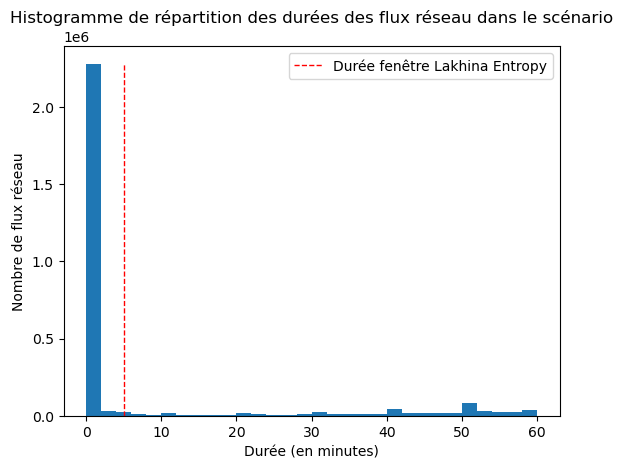

In [15]:
duration = scenario['Dur'].apply(lambda x: x/60)

counts, _, _ = plt.hist(duration, bins=30)
plt.plot([5, 5], [0, max(counts)], 'r--', linewidth=1, label='Durée fenêtre Lakhina Entropy')

plt.xlabel("Durée (en minutes)")
plt.ylabel("Nombre de flux réseau")
plt.title("Histogramme de répartition des durées des flux réseau dans le scénario")
plt.legend(loc=0)

plt.show()

La majorité des flux sont d'une durée inférieure à la taille de la fenêtre proposée dans le papier Lakhina Entropy [2]. Cependant, on observe que des flux réseau sont étalés sur une durée bien plus grande que la fenêtre d'échantillonage. Il faudra traiter ces cas particuliers dans le traitement suivant.

### 3 - Lakhina Entropy

#### Création de la matrice d'entropie

Définition des variables et des constantes

In [16]:
testScenario = True
### Sampling Window de 5 minutes
SW = 5

On relève les botnets dans notre échantillon de scénario pour la partie évaluation suivante.

In [17]:
sampled = False

if sampled:
    end = 1000000
    sampled_scenario = scenario[:end]

    sampled_botnet_data = sampled_scenario[sampled_scenario['Label']==1]
    print(f"Nombre de netflows issus de botnet : {len(sampled_botnet_data)}")
    sampled_botnet_data.loc[sampled_botnet_data.index[0]]

Nombre de netflows issus de botnet : 2320


StartTime    2011-08-10 11:04:24.863449
Dur                            0.000278
Proto                               udp
SrcAddr                   147.32.84.165
Sport                              1025
DstAddr                     147.32.80.9
Dport                                53
TotPkts                               2
TotBytes                            203
Label                                 1
Class                            Botnet
Name: 675537, dtype: object

On calcule les trois matrices d'entropie par aggrégation des netflows par tranches de temps (ici 5 minutes) et par adresse IP source, puis par adresse IP de destination, par port de destination ou par port source. Pour chacun des 3 tableaux, on cacule l'entropie de chaque adresse IP source à chaque tranche de temps en sommant le nombre total de paquets échangés.

In [191]:
def getOdFlows(scenario, feature, SW):
    """
    Group by time windows of 5 minutes, SrcAddr, Sport, DstAddr, and Dport
    getOdFlows function returns a DataFrame
    """
    return scenario.groupby([pd.Grouper(key='StartTime', freq=str(SW)+'Min'), 'SrcAddr', feature])['TotPkts'].sum()

def partial_entropy(serie):
    """
    Compute a part of the entropy calculation, modified to accelerate the computation with Pandas (log properties + factorisation) 
    """
    return np.sum(serie * np.log2(serie))

# Entropy matrix for Destination IP Address
if sampled:
    odFlows = getOdFlows(sampled_scenario, 'DstAddr', 5)
else:
    odFlows = getOdFlows(scenario, 'DstAddr', 5)
gb = odFlows.groupby(['StartTime', 'SrcAddr'])
S = gb.sum()
_partial_entropy = gb.agg(partial_entropy)
H_DestIP = np.log2(S) - _partial_entropy/S
print("H_DestIP\n", H_DestIP,"\n")

# Entropy matrix for Destination Port
if sampled:
    odFlows = getOdFlows(sampled_scenario, 'Dport', 5)
else:
    odFlows = getOdFlows(scenario, 'Dport', 5)
gb = odFlows.groupby(['StartTime', 'SrcAddr'])
S = gb.sum()
_partial_entropy = gb.agg(partial_entropy)
H_Dport = np.log2(S) - _partial_entropy/S
print("H_Dport\n", H_Dport,"\n")

# Entropy matrix for Source Port
if sampled:
    odFlows = getOdFlows(sampled_scenario, 'Sport', 5)
else:
    odFlows = getOdFlows(scenario, 'Sport', 5)
gb = odFlows.groupby(['StartTime', 'SrcAddr'])
S = gb.sum()
_partial_entropy = gb.agg(partial_entropy)
H_Sport = np.log2(S) - _partial_entropy/S
print("H_Sport\n", H_Sport,"\n")

H_DestIP
 StartTime            SrcAddr          
2011-08-10 09:45:00  0.0.0.0              0.0
                     00:15:17:2c:e5:2d    0.0
                     1.144.156.226        0.0
                     1.144.5.55           0.0
                     1.148.38.207         0.0
                                         ... 
2011-08-10 15:50:00  99.7.152.85          0.0
                     99.7.43.36           0.0
                     99.75.38.4           0.0
                     99.91.151.102        0.0
                     99.93.188.5          0.0
Name: TotPkts, Length: 1084955, dtype: float64 

H_Dport
 StartTime            SrcAddr      
2011-08-10 09:45:00  0.0.0.0          0.0
                     1.144.156.226    0.0
                     1.144.5.55       0.0
                     1.148.38.207     0.0
                     1.153.119.105    0.0
                                     ... 
2011-08-10 15:50:00  99.7.152.85      0.0
                     99.7.43.36       0.0
                

On normalise et centre les matrices d'entropie obtenues, puis on les concatène suivant les lignes pour obtenir la matrice d'entropie finale.

In [192]:
def df_to_matrix(df):
    # Reshape the DataFrame to a matrix
    matrix = df.unstack(fill_value=0).to_numpy()

    # Normalize the entire matrix by its total energy
    energy = np.sqrt(np.sum(matrix**2))
    matrix = matrix / energy

    # Center the data
    mean = np.mean(matrix, axis=0)
    matrix = matrix - mean

    return matrix

# Transform the DataFrame into a matrix and process it
H_DestIP_Numpy = df_to_matrix(H_DestIP)
H_Dport_Numpy = df_to_matrix(H_Dport)
H_Sport_Numpy = df_to_matrix(H_Sport)

# Concatenate the three matrices along the rows
H = np.concatenate((H_DestIP_Numpy, H_Dport_Numpy, H_Sport_Numpy), axis=1)

print("Il y a {} valeurs vides (égales à 0) pour {} valeurs au total.".format(
    np.count_nonzero(H_DestIP_Numpy == 0),
    np.size(H_DestIP_Numpy)
))
print(f"La matrice d'entropie est de dimensions {H.shape}, tandis que les dimensions de la matrice d'entropie pour l'adresse IP de destination sont {H_DestIP_Numpy.shape}.")
assert H.shape[1] == H_DestIP_Numpy.shape[1] + H_Dport_Numpy.shape[1] + H_Sport_Numpy.shape[1]

Il y a 38251930 valeurs vides (égales à 0) pour 40114882 valeurs au total.
La matrice d'entropie est de dimensions (74, 1625669), tandis que les dimensions de la matrice d'entropie pour l'adresse IP de destination sont (74, 542093).


Observons les valeurs obtenues pour un ODflow particulier de la matrice d'entropie où les données sont regroupées par adresses IP de destination.

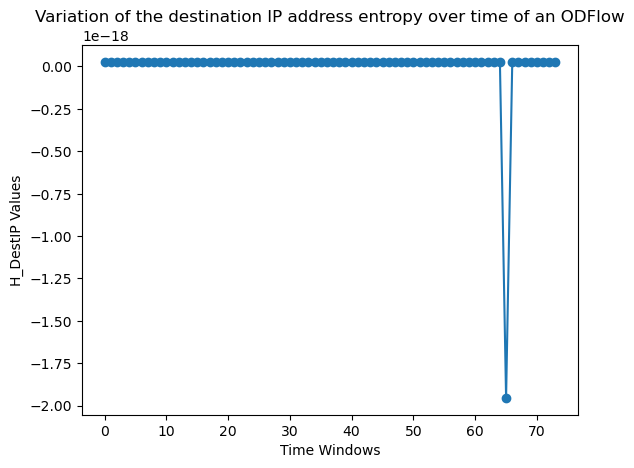

In [193]:
# Extract a column
not_empty_col = np.where(H_DestIP_Numpy != 0)[1][1]
column = H_DestIP_Numpy[:,not_empty_col]

# Plot the first column
plt.plot(column, marker='o', linestyle='-')
plt.xlabel('Time Windows')
plt.ylabel('H_DestIP Values')
plt.title('Variation of the destination IP address entropy over time of an ODFlow')
plt.show()

#### Analyse en composantes principales (ACP) de la matrice d'entropie

Appliquons maintenant une ACP sur la matrice d'entropie complète H.

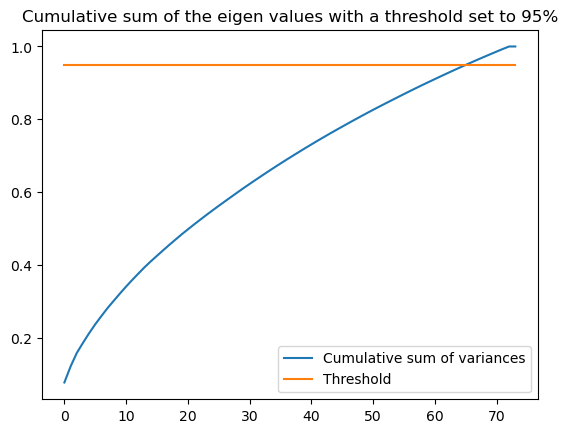

In [243]:
# Perform PCA with the maximum number of components to get the optimal number of principal components to keep
pca = PCA()
pca = pca.fit(H)

cumul_sum = np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_)

absc = [i for i in range(num_components)]
plt.plot(cumul_sum, label="Cumulative sum of variances")
plt.plot(absc, [0.95 for _ in absc], label="Threshold")
plt.title("Cumulative sum of the eigen values with a threshold set to 95%")
plt.legend()

In [241]:
# Perform PCA by fitting the data and project them onto the first num_components principal components
num_components = 73
pca = PCA(n_components=num_components)
projected_data = pca.fit_transform(H)

# Compute the orthogonal vectors u_i as defined in the article
norms = np.linalg.norm(projected_data, axis=0)
u_vectors = projected_data / norms[np.newaxis, :]

In [249]:
pca.explained_variance_

array([1.25677397e-03, 7.16722017e-04, 6.02930120e-04, 4.54786062e-04,
       4.33900806e-04, 4.03015418e-04, 3.70882181e-04, 3.59317562e-04,
       3.26037701e-04, 3.23888767e-04, 3.13937312e-04, 2.97908657e-04,
       2.87813364e-04, 2.82614132e-04, 2.60667166e-04, 2.50027389e-04,
       2.46668143e-04, 2.43998551e-04, 2.36017426e-04, 2.34357186e-04,
       2.21908416e-04, 2.20677340e-04, 2.13591686e-04, 2.12314190e-04,
       2.06364741e-04, 2.04266260e-04, 1.99922804e-04, 1.98567637e-04,
       1.96909709e-04, 1.95986553e-04, 1.89548368e-04, 1.87788769e-04,
       1.85795376e-04, 1.84410425e-04, 1.81098461e-04, 1.77707919e-04,
       1.75835983e-04, 1.72705544e-04, 1.71104413e-04, 1.69576129e-04,
       1.66374303e-04, 1.64821059e-04, 1.61285718e-04, 1.60827595e-04,
       1.56593143e-04, 1.55380824e-04, 1.54142411e-04, 1.52584220e-04,
       1.50600231e-04, 1.49390054e-04, 1.46647278e-04, 1.43898927e-04,
       1.42466803e-04, 1.40899376e-04, 1.40340264e-04, 1.39790197e-04,
      

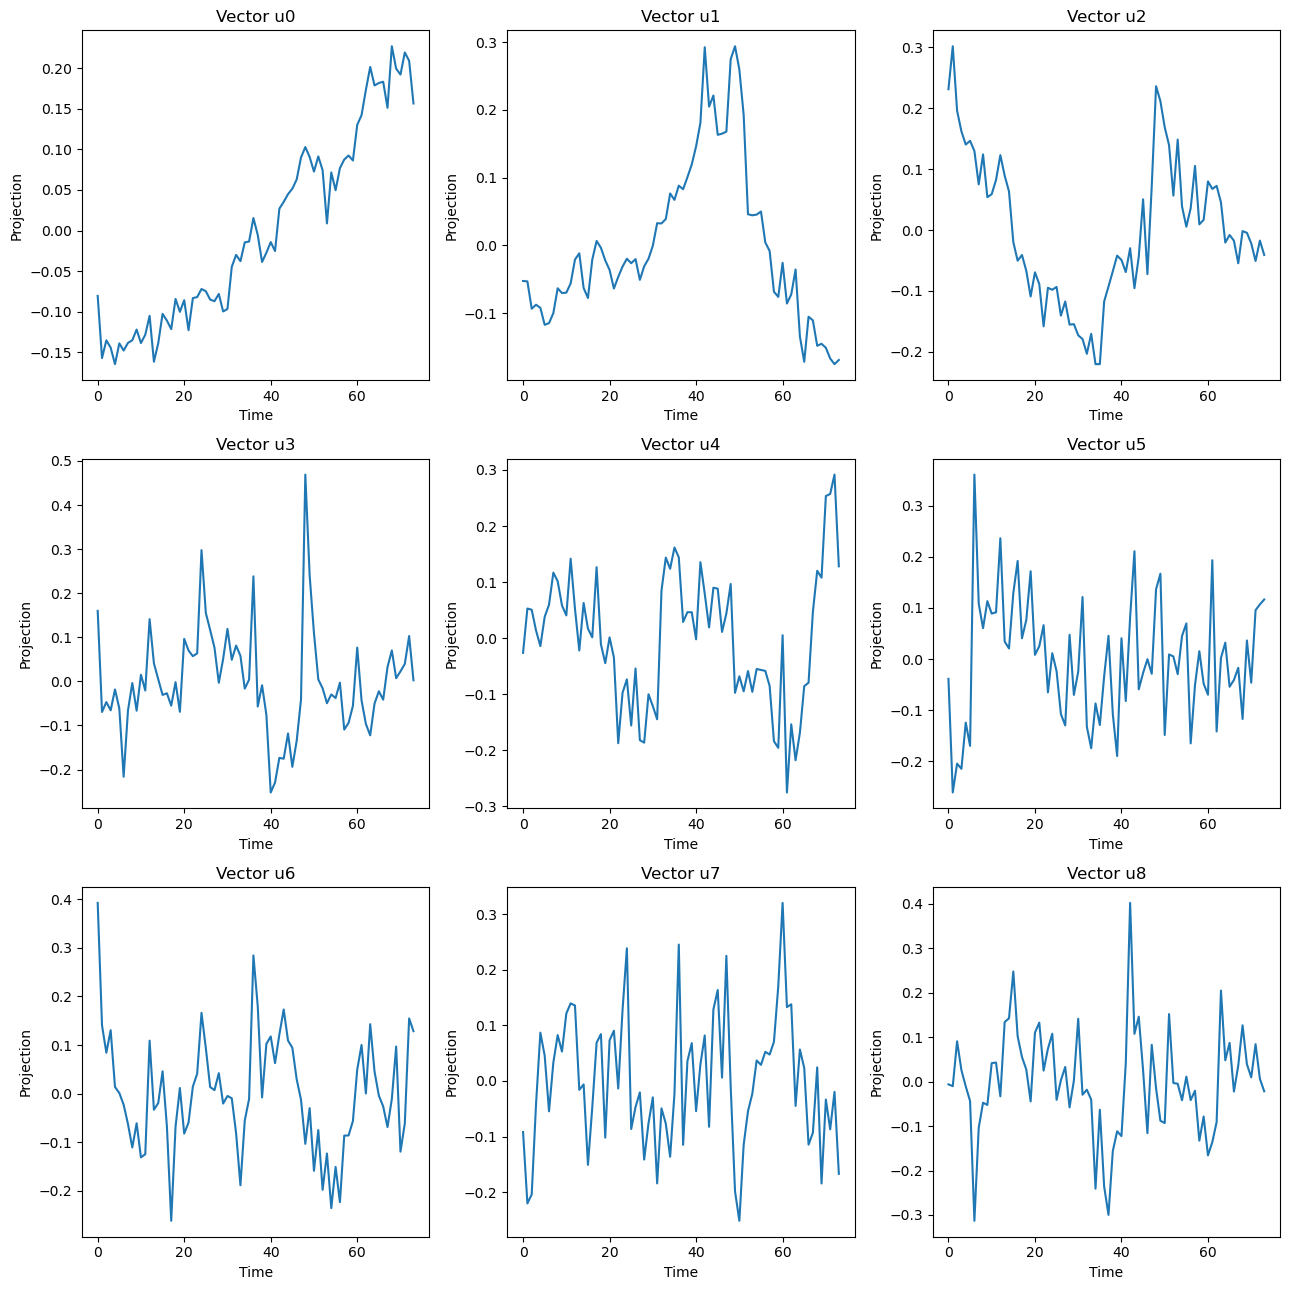

In [227]:
fig, axs = plt.subplots(3, 3, figsize=(13,13))

for i in range(num_components):
    axs[i//3, i%3].plot(u_vectors[:, i])
    axs[i//3, i%3].set_xlabel("Time")
    axs[i//3, i%3].set_ylabel("Projection")
    axs[i//3, i%3].set_title(f"Vector u{i}")

fig.tight_layout()

On calcule le seuil de détection (Q-statistic) avec un niveau de confiance à 95% à partir de la matrice obtenue précédemment, à l'aide d'une ACP ne réduisant pas la dimension de la matrice H. On fixe également par observation des graphiques ci-dessus le nombre de dimensions dans les sous-espaces normal et d'anomalies.

In [228]:
# Number of vectors u_i in the normal subspace
dim_normal_subspace = 3

# We set a confidence level of 95%
alpha = "95%"
percentiles = dict(zip(["99%", "95%"], [2.33, 1.645]))

# Get the explained variance ratios from PCA
explained_variance = pca.explained_variance_
print(explained_variance, "\n")

# Compute the constants φ1, φ2, and φ3
phi1 = np.sum(explained_variance[dim_normal_subspace:])
phi2 = np.sum(explained_variance[dim_normal_subspace:] ** 2)
phi3 = np.sum(explained_variance[dim_normal_subspace:] ** 3)
print(explained_variance[dim_normal_subspace:], "\n")

# Compute h0
h0 = 1 - ((2 * phi1 * phi3) / (3 * phi2**2))

# Compute δ²_α using the Q-statistic formula
term1 = (percentiles[alpha] * np.sqrt(2 * phi2 * h0**2)) / phi1
term2 = (phi2 * h0 * (h0 - 1)) / phi1**2
delta_squared_alpha = phi1 * ((term1 + 1 + term2)**(1/h0))

print("Threshold value δ²_α at", alpha, "confidence level:", delta_squared_alpha)

[0.00125677 0.0007167  0.00060286 0.00045319 0.00043335 0.00040122
 0.00036933 0.00035629 0.00032168] 

[0.00045319 0.00043335 0.00040122 0.00036933 0.00035629 0.00032168] 

Threshold value δ²_α at 95% confidence level: 0.004915614014409678


Calculons maintenant les matrices de projections sur les espaces normal et d'anomalies, comme décrit dans l'article.

In [229]:
P_normal = projected_data[:dim_normal_subspace, :].T
C_normal = P_normal.dot(P_normal.T)
C_anomalous = np.eye(len(C_normal)) - C_normal

print(f"{C_normal.shape = } and {C_anomalous.shape = }")

C_normal.shape = (9, 9) and C_anomalous.shape = (9, 9)


In [230]:
projected_data.shape

(74, 9)

#### Extraction des anomalies : Détection

On cherche maintenant à identifier des tranches temporelles contenant des anomalies. On cherche donc des lignes de la matrices H liées à l'activité d'un Botnet.

In [231]:
temporal_slices = H_DestIP.index.get_level_values(0).unique()
times = []

# Loop through each element in H_DestIP_Residual
for t, y in enumerate(projected_data):
    spe = np.linalg.norm(C_anomalous.dot(y))**2
    if spe > delta_squared_alpha:
        times.append(t)

# Print informations about the intermediates results
print(f"Number of temporal slices: {len(temporal_slices)}")
print(f"Number of anomalous temporal slices: {len(times)}")
print(f"Indices of the temporal slices where anomalies are: {times}")
print("Botnets are spotted on the temporal slices beginning at: {}.".format(
    list(temporal_slices[times].strftime("%Y-%m-%d %h:%m:%s").to_numpy())
))

Number of temporal slices: 74
Number of anomalous temporal slices: 25
Indices of the temporal slices where anomalies are: [0, 1, 2, 3, 6, 24, 34, 36, 42, 43, 48, 49, 50, 60, 61, 62, 63, 64, 65, 68, 69, 70, 71, 72, 73]
Botnets are spotted on the temporal slices beginning at: ['2011-08-10 09:45:00', '2011-08-10 09:50:00', '2011-08-10 09:55:00', '2011-08-10 10:00:00', '2011-08-10 10:15:00', '2011-08-10 11:45:00', '2011-08-10 12:35:00', '2011-08-10 12:45:00', '2011-08-10 13:15:00', '2011-08-10 13:20:00', '2011-08-10 13:45:00', '2011-08-10 13:50:00', '2011-08-10 13:55:00', '2011-08-10 14:45:00', '2011-08-10 14:50:00', '2011-08-10 14:55:00', '2011-08-10 15:00:00', '2011-08-10 15:05:00', '2011-08-10 15:10:00', '2011-08-10 15:25:00', '2011-08-10 15:30:00', '2011-08-10 15:35:00', '2011-08-10 15:40:00', '2011-08-10 15:45:00', '2011-08-10 15:50:00'].


In [203]:
botnet_data["StartTime"].unique()

<DatetimeArray>
['2011-08-10 11:04:24.863449', '2011-08-10 11:04:27.118993',
 '2011-08-10 11:04:27.140727', '2011-08-10 11:06:23.268442',
 '2011-08-10 11:06:23.606888', '2011-08-10 11:06:36.076294',
 '2011-08-10 11:06:36.536447', '2011-08-10 11:06:37.477233',
 '2011-08-10 11:06:38.849594', '2011-08-10 11:06:40.383196',
 ...
 '2011-08-10 15:48:46.445764', '2011-08-10 15:48:46.445905',
 '2011-08-10 15:48:47.056449', '2011-08-10 15:48:47.056523',
 '2011-08-10 15:48:47.447119', '2011-08-10 15:48:48.058272',
 '2011-08-10 15:48:48.338346', '2011-08-10 15:48:48.448462',
 '2011-08-10 15:48:49.059334', '2011-08-10 15:48:49.449944']
Length: 40961, dtype: datetime64[ns]

#### Extraction des anomalies : Identification

On cherche maintenant à identifier parmi les tranches temporelles anormales les ODflows contenant ces anomalies. On cherche donc les indices des colonnes de la matrices H liées à l'activité d'un Botnet.

In [75]:
anomalous_OD_flows = []

for t in range(len(anomalous_windows)):
    timeWindow = anomalous_windows[t, :]
    maxEntropy = max(timeWindow)
    max_od_flow = np.where(timeWindow==maxEntropy)[0]
    print(max_od_flow[0])
    anomalous_OD_flows.append(max_od_flow)

print(times)
print(anomalous_OD_flows[:])
print(H_DestIP.iloc[times])

# L'adresse IP de l'hôte infectée est : ['147.32.84.165']

67256
42718
[10, 20]
[array([67256]), array([42718])]
StartTime            SrcAddr     
2011-08-10 10:00:00  85.130.37.41    0.0
Name: TotPkts, dtype: float64


In [53]:
def construct_theta_k(k, num_flows):
    """
    Function to construct the binary matrix θ for an OD flow k
    """
    theta_k = np.zeros((4 * num_flows, 4))

    for m in range(1, 5):
        theta_k[4 * k + m - 1, :] = 1
        
    return theta_k

def construct_theta(i, )

def calculate_feature_state_vector(h_star, theta_k, fk):
    """
    Function to calculate the feature state vector for an anomaly
    """
    return h_star + np.dot(theta_k, fk)

def identify_anomalous_flow(anomaly_vector, num_flows):
    """
    Function to identify the OD flow causing the anomaly
    """
    min_residual_norm = float('inf')
    anomalous_flow = None
    
    for k in range(num_flows):
        theta_k = construct_theta(k, num_flows)
        feature_state_vector = calculate_feature_state_vector(h_star, theta_k, anomaly_vector)
        residual_norm = np.linalg.norm(anomaly_vector - feature_state_vector)
    
        if residual_norm < min_residual_norm:
            min_residual_norm = residual_norm
            anomalous_flow = k

    return anomalous_flow

# Loop through each anomaly window and identify the anomalous flow(s)
num_time_windows = anomalous_windows.shape[0]
num_flows = anomalous_windows.shape[1]
print(f"Nombre de tranches temporelles anormales : {num_time_windows}")
print(f"Nombre d'ODFlow anormaux : {num_flows}")

for t in range(num_time_windows):
    # 1. for each hypothesized anomaly F_i, i = 1, ..., I, compute y_i*using Equation (1)
    # 2. choose anomaly F_j as j = arg min_i(norm(C_hat * y_i*)).
    anomaly_vector = anomalous_windows[t, :]
    anomalous_flow = identify_anomalous_flow(anomaly_vector, num_flows)
    print(f"Anomaly at time point {t+1} caused by OD flow {anomalous_flow + 1}")
    
print(construct_theta(1, num_flows)[8])
